<a href="https://colab.research.google.com/github/jiho-kang/NLP_RecSys_Project/blob/main/tried_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab 환경에서 보는 것을 권장합니다.


# 기본적인 환경설정

#### mecab 및 필요 모듈 설치

In [ ]:
!pip install transformers

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:

%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

#### 데이터 불러오기

In [ ]:
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# df = pd.read_excel('/content/drive/MyDrive/policy_metetable(AIB전달용).xlsx')
# 엑셀파일 안읽힐때 이거사용쓰
df = pd.read_excel('/content/drive/MyDrive/policy_metetable(AIB전달용).xlsx', engine='openpyxl')

In [ ]:
ans = pd.read_csv('//content/drive/MyDrive/웰로/data/wello_admin_답지.csv', error_bad_lines=False)

b'Skipping line 2439: expected 24 fields, saw 25\n'


# 태깅 모델

## 1. 개체명 인식기를 활용한 자체 태그 추출방식

태깅을 위한 Text 내 개체명 인식을 진행.

<br>  





### 1) Konlpy 패키지의 형태소 분석기 중 Mecab 사용 및 BIO 표현을 통한 개체명 인식기 직접학습.

* 선정 이유:  
여러 조사에 따라 Mecab이 성능이 준수하면서도 가장 빠른 컨디션의 한국어 형태소 분석기로 사용된다는 점을 감안해 이용했다. 가장 널리 사용되는 BIO 학습방법을 통해 개체명 인식기를 만들고, 이를 통해 태그를 추출할 것은 목표로 두었음.

#### 가설 i)  
**정책 데이터는 오타, 띄어쓰기 등 어느정도 올바른 문장/단어이므로 성능이 평균 이상만 된다면 속도가 빠른 Mecab을 사용하는 것이 유리할 것이다.**
 
* 방법:  
 - Mecab의 품사 태깅, 명사 추출을 이용해 각 문맥 데이터의 전처리를 빠르게 진행해 키워드 및 태그를 추출하는 방식.

* 이슈 및 특이사항:  
 - 예상과 달리, 문맥 데이터가 복잡해서 속도보다 Mecab 보다 성능이 좋을 것으로 예상되는 다른 model을 응용할 필요가 있음.

<br>

#### 가설 ii)  
**BIO 표현을 이용해, 특정 키워드에 태그로 반환해 특성(Feature) 별 태그를 추출할 수 있다.**

 * 방법:  
  - Mecab으로 명사를 뽑아낸 뒤, BIO 표현을 이용하여 특정 키워드에 대해 태그(B)를, 그 외에는 모두 (O)를 반환하는 모델을 작성한다.   

 * 이슈 및 특이사항:  
  -  키워드에 따른 태그 추출이 쉬운 특성에만 적용이 가능하다.  
 ㄴ> 성별(남성/여성/무관), 신청절차(온라인/오프라인/복합) 등 단순한 특성에서만 빈도에 따른 태그 추출의 방법으로 처리 가능하다.

  -  키워드 간 복잡한 연관성이 있는 경우, 그 규칙을 찾는 것이 어렵고, 키워드가 무수히 많을 수 있다.

<br>  

<br>  

### 코드 구현

#### 개체명 인식기 설계 (신청절차 태그추출)


In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

In [ ]:
import copy
# 개체명 인식을 위한 키워드 별 태그파악 및 문장 분리 작업

'''
A10-00 : 무관 태그
A10-01 : 온라인 태그
A10-02 : 오프라인 태그
O : 이외의 문자
BERT 스페셜 토큰 : [CLS], [SEP]
[PAD] : 토큰 길이(샘플 별로 문장의 길이가 다르므로)가 기준에 비해 짧을 경우 채워주는 패딩 토큰
오프라인과 온라인을 나타내는 키워드를 제외하고는 모두 O로 표시하여 무시한다.

'''

df1 = df[:2000]['신청절차'].copy()  # 2000개 샘플만 진행해본다.
d = pd.DataFrame()
df1 = df1.fillna('아무것도없는샘플')
for n, i in enumerate(df1):
  print(n)
  tok = []        # 문장 토큰을 넣을 곳
  
  if i != '아무것도없는샘플':
    token = mecab.nouns(i)
    tok.append([f'Sentence: {n}','[CLS]]','[CLS]'])
    for j in token:   # 토큰의 조건 별 태그 추출
      if sum(j.count(x) for x in ['방문','우편','서면','팩스','은행','영업점','사무소','내방']) >= 1 :
        tok.append([f'Sentence: {n}',j,'A10-02'])
      elif sum(j.count(x) for x in ['모바일','ARS','전화','민원24','온라인','이메일','인터넷','홈택스','홈페이지','앱']) >= 1 :
        tok.append([f'Sentence: {n}',j,'A10-01'])  
      else:
        tok.append([f'Sentence: {n}', j,'OO'])
  elif i == '아무것도없는샘플':
    tok.append([f'Sentence: {n}','[CLS]]','[CLS]'])
    tok.append([f'Sentence: {n}', '아무것도없는샘플','A10-00'])

  tok.append([f'Sentence: {n}','[SEP]','[SEP]'])
  a =  pd.DataFrame(tok)
  d = pd.concat([d,a], axis=0)

d.columns = ['Sentence #','Word','Tag']

In [ ]:
d

,Sentence #,Word,Tag
0,Sentence: 0,[CLS],[CLS]
1,Sentence: 0,신청,OO
2,Sentence: 0,읍,OO
3,Sentence: 0,동사무소,A10-02
4,Sentence: 0,보장,OO
...,...,...,...
8,Sentence: 1999,일자리,OO
9,Sentence: 1999,담당,OO
10,Sentence: 1999,부서,OO
11,Sentence: 1999,신청,OO


In [ ]:
# 정리된 데이터 프레임 내에서 문장 별로 단어와 태그를 정리해준다.
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w,  t in zip(s["Word"].values.tolist(),
                                                          #  s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = SentenceGetter(d)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences] # 문장의 토큰 리스트
labels = [[s[1] for s in sent] for sent in getter.sentences]                  # 문장의 라벨(태그) 리스트

In [ ]:
tag_values = list(set(d["Tag"].values))         
tag_values.append("[PAD]")
tag2idx = {t: i for i, t in enumerate(tag_values)}
index_to_ner = {i:j for j, i in tag2idx.items()}

In [ ]:
# 태그의 종류
tag_values

['OO', '[SEP]', 'A10-02', 'A10-00', 'A10-01', '[CLS]', '[PAD]']

#### Bert 토크나이저로 학습진행

In [ ]:
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [ ]:
# word piece tokenizing 하면서 label이 단어를 잃지 않도록 처리하는 함수
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        # 단어를 토큰화 하고, 떨어진 서브워드 개수를 센다.
        tokenized_word = tokenizer.tokenize(str(word))
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        # 최종 토크나이즈드 워드 
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = list()
# Bert 토크나이저로 각각의 words에 따른 labels을 인식시켜준다
for sent, labs in zip(sentences, labels):
  tokenized_texts_and_labels.append(tokenize_and_preserve_labels(sent, labs))

In [ ]:

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]
print(tokenized_texts[1])
print(labels[1])

['[CLS]', ']', '개', '##벌', '신', '##청', '경우', '모', '##바', '##일', '국', '##세', '##청', '홈', '택', '##스', '앱', '인', '##터', '##넷', '홈', '택', '##스', '서', '##비스', '서', '##면', '신', '##청', '가', '##능', '개', '##별', '신', '##청', '경우', '인', '##터', '##넷', '홈', '택', '##스', '서', '##면', '신', '##청', '가', '##능', '[SEP]']
['[CLS]', '[CLS]', 'OO', 'OO', 'OO', 'OO', 'OO', 'A10-01', 'A10-01', 'A10-01', 'OO', 'OO', 'OO', 'OO', 'OO', 'OO', 'A10-01', 'A10-01', 'A10-01', 'A10-01', 'OO', 'OO', 'OO', 'OO', 'OO', 'A10-02', 'A10-02', 'OO', 'OO', 'OO', 'OO', 'OO', 'OO', 'OO', 'OO', 'OO', 'A10-01', 'A10-01', 'A10-01', 'OO', 'OO', 'OO', 'A10-02', 'A10-02', 'OO', 'OO', 'OO', 'OO', '[SEP]']


In [ ]:
# 토큰 최대길이 설정
MAX_LEN = 40

In [ ]:
# 토큰을 Bert 토크나이저의 사전에 맞는 인덱스로 변환하고, 특정길이(40)에 맞춰 짧을 경우 0으로 채운다.
from keras.preprocessing.sequence import pad_sequences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
# 라벨로 패딩처리 진행, 길이가 짧을 경우 [PAD]로 채워준다.
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["[PAD]"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
# 패딩처리를 확인하기 위한 마스킹
import numpy as np
attention_masks = np.array([[int(i != tokenizer.convert_tokens_to_ids("[PAD]")) for i in ii] for ii in input_ids])

In [ ]:
# 학습, 검증 셋 분류
from sklearn.model_selection import train_test_split
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)

tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [ ]:
from transformers import TFBertModel
import tensorflow as tf


SEQ_LEN = MAX_LEN

# Huggingface의 Bert 모델 중 bert-base-mulitilingual로 한국어 지원 진행
model1 = TFBertModel.from_pretrained("bert-base-multilingual-cased", from_pt=True, num_labels=len(tag2idx), output_attentions = False,
  output_hidden_states = False)

token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids') # 토큰 인풋
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks') # 마스크 인풋

bert_outputs = model1([token_inputs, mask_inputs])
bert_outputs = bert_outputs[0] # shape : (Batch_size, max_len, 30(개체의 총 개수))
nr = tf.keras.layers.Dense(len(tag2idx), activation='softmax')(bert_outputs) # shape : (Batch_size, max_len)

nr_model1 = tf.keras.Model([token_inputs, mask_inputs], nr)

nr_model1.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00002), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['sparse_categorical_accuracy'])
nr_model1.summary()

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 40)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]']            
                                tentions(last_hidde                                               
                                n_state=(None, 40,                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
%%time
nr_model1.fit([tr_inputs, tr_masks], tr_tags, validation_data=([val_inputs, val_masks], val_tags), batch_size = 64, epochs=3, shuffle=False)

Epoch 1/3
29/29 [==============================] - 32s 590ms/step - loss: 0.4796 - sparse_categorical_accuracy: 0.8569 - val_loss: 0.0575 - val_sparse_categorical_accuracy: 0.9836
Epoch 2/3
29/29 [==============================] - 14s 500ms/step - loss: 0.0366 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.0108 - val_sparse_categorical_accuracy: 0.9976
Epoch 3/3
29/29 [==============================] - 15s 504ms/step - loss: 0.0091 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.0038 - val_sparse_categorical_accuracy: 0.9986
CPU times: user 46.5 s, sys: 4.9 s, total: 51.4 s
Wall time: 1min 36s


In [ ]:
# 문장을 넣으면 태그를 뽑아내는 개체명 인식기 함수 작성 (신청절차 태그)
def apply_tags(test_sentence):
  
  tokenized_sentence = np.array([tokenizer.encode(test_sentence, max_length=MAX_LEN, truncation=True, padding='max_length')])
  tokenized_mask = np.array([[int(x!=1) for x in tokenized_sentence[0].tolist()]])
  ans = nr_model1.predict([tokenized_sentence, tokenized_mask])
  ans = np.argmax(ans, axis=2)

  tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, ans[0]):
    if (token=='[CLS]'):
      pass
    elif (token=='[SEP]'):
      pass
    elif (token=='[PAD]'):
      pass
    elif (token != '[CLS]' or token != '[SEP]'):
      new_tokens.append(token)
      new_labels.append(index_to_ner[label_idx])
  
  return new_labels

In [ ]:
# 개체명 인식기 모델 사용해보기
print(apply_tags('인터넷 또는 직접 방문해서 신청 가능'))

['A10-01', 'A10-01', 'A10-01', 'OO', 'OO', 'A10-02', 'A10-02', 'OO', 'OO', 'OO', 'OO', 'OO']


#### 모델링 및 태그 추출 결과:  

* 모델의 성능은 1에 가까워 키워드 또는 태그 필터링 역할로 사용이 가능하다.
* 신청절차와 같은 단순히 온라인 또는 오프라인, 두 가지가 모두 있으면 복합으로 표현할 수 있는 feature에 사용이 유용하다.  

#### 문제점

  - a) 불가, 제외 등의 키워드가 있는 경우에도 해당 키워드가 존재하므로 잘못된 태그를 추출할 수있다. (ex: 방문 접수만 가능, 온라인 접수는 불가)  

  - b) 키워드 간 복잡한 연관성을 파악하지 못해 태그 내 관계가 단순한 경우가 아니면 이러한 개체명 인식기만으로 태그 추출이 어렵다.

#### 개선방안  
  - a) 불가, 제외 등의 상쇄 키워드에 대한 태그를 추가 학습하고, 결과값에서 태그 근처에 상쇄 태그가 있는 경우, 이를 제거하여 처리한다.  

  - b) 태그 또는 키워드를 변환하여 추가적인 신경망 모델을 사용해 복잡한 관계를 파악하도록 한다.

<br>

<br>

---

<br>

<br>

### 2) KakaoBrain 개발 자연어처리 라이브러리 Pororo를 이용 

* 선정 이유:  
kakaobrain 사에서 올해 2월에 선보인 라이브러리로 자체적인 개체명인식 기능을 가지고 있어, 사용할 수 있는 특성에서는 최대한 활용하기 위함

#### 가설)  
**개체명 인식관련 모듈을 가진 라이브러리 pororo를 이용해 문맥 내 개체명을 필터링 해 태깅 정보를 가져올 수 있을 것이다.**

* 방법:  
  - pororo 라이브러리 내 자체 개체명 인식 기능을 활용해 지역(loacation), 성별(gender), 연령대(child/adult) 등을 파악한 뒤, 필터링을 거쳐 태그 추출  
ex) 지역(loca) 등의 기능을 정책 및 유저 데이터셋의 '시/도' 또는 '시군구' 파악에 사용

* 이슈 및 특이사항:  
  - 지역명이 포함된 기관명을 분해하여 지역명으로 인식함.
  - 정책이라는 특수한 도메인에 사용되는 말뭉치가 아닌, 일상 대화에서 사용되는 말뭉치임.

<br>  

<br>  


### 코드 구현

#### 개체명 인식기 시연

pororo는 직접 학습하는 것이 아닌 패키지에 들어있는 개체명 인식 모듈을 사용

In [ ]:
from pororo import Pororo

ner = Pororo(task="ner", lang="kor")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



In [ ]:
print(df['지원대상'][20000])
print(ner(df['지원대상'][20000]))

○ 도내 시설채소 재배 농업인 및 농업법인

기업인||중소기업/소상공인||농축수산인
[('○', 'O'), (' ', 'O'), ('도내', 'O'), (' ', 'O'), ('시설채소', 'O'), (' ', 'O'), ('재배', 'O'), (' ', 'O'), ('농업인', 'CIVILIZATION'), (' ', 'O'), ('및', 'O'), (' ', 'O'), ('농업법인', 'O'), (' ', 'O'), ('기업인', 'OCCUPATION'), ('||중소기업', 'CIVILIZATION'), ('/', 'O'), ('소상공인', 'CIVILIZATION'), ('||', 'O'), ('농축수산인', 'CIVILIZATION')]




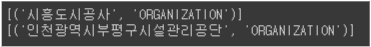

#### 태그 추출 결과:  

  - 일반적인 단어들에 대해 어느정도 인식을 하지만, 본래 목표하던 시/도, 시군구에 대해서도 구분이 명확히 되지않아 사용이 어려움  

  ex) 상위 태그인 ‘강원도’와 하위태그인 ‘홍천군’ 모두 LOCATION, 하위태그인 ‘동해시’는 CITY로 나오는 상황
    
    [('강원도', 'LOCATION'), ('강원', 'LOCATION'), ('동해시', 'CITY'),
     ('홍천군', 'LOCATION'), ('평창군', 'LOCATION'), ('양구군', 'LOCATION'), ('양양군', 'LOCATION')]
    


#### 문제점:  

  - 지역(시/도) 또는 지역(시군구)의 태깅 관련해서라도 사용을 하고자 했으나, 이마저도 상당수의 키워드가 개체명이 통일되지 않아 fine tunning에 시간이 많이 소모됨.
  - 데이터셋의 도메인에 특화된 개체명인식이 되지 않아 다른 태그들에 있어서도 큰 효과가 없음

<br>



---

<br>

### 3) KoalaNLP 패키지의 API를 이용.

* 선정 이유:  
    - pororo와 같이 개체명 인식 기능을 활용할 수 있는 패키지이며, API 사용권한을 받아 개체명 사전 등록이 가능할 것으로 판단되어, 이를 최대한 활용해 직접 개체명 학습하는 것을 줄이기 위함.

#### 가설) 
**패키지 내 사전 등록을 통해 개체명 필터링 후 태깅 정보를 가져올 수 있을 것이다.**

* 방법: 
  - 2) pororo와 동일하게 자체 개체명 인식 기능을 활용, 사용자 사전 등록을 통해 개체명 추가를 시도해보고 개체명 필터링을 하여 태그 추출을 진행

* 이슈 및 특이사항:  
  - pororo와 마찬가지로 지역명이 포함된 기관명을 분해하여 지역명으로 인식함.
  - 정책이라는 특수한 도메인에 사용되는 말뭉치가 아닌, 일상 대화에서 사용되는 말뭉치임.

<br>  


#### 태그 추출 결과:  

  - pororo 패키지 사용시와 같은 성능을 보임


#### 문제점:  

  - pororo 패키지 사용시와 같은 문제를 보임 (ex: 시/도(LOCA)와 기관(ORGANIZATION)의 구분을 못하는 등)


<br>

---

<br>

## 2. 직접 학습시킨 개체명 인식기 + 신경망 모델학습 통한 문맥에 따른 태그 추출

Text 내 개체명 인식을 통해 태그 추출 후 딥러닝 모델 적용을 통해 태그 추출기능 강화

### 1) 개체명 인식기 output + Bert를 통한 추출

* 선정 이유:  
    - 개체명 인식을 통해 나온 output 값은 O와 태그(ex:A10-01)값으로 이루어져 있는데, Bert 모델의 양방향 인코더로 문맥(순서)를 잘 파악할 수 있고, 위치 임베딩을 통해 문맥 내 태그의 위치를 고려한 최종 태그 예측을 학습하기 위함.

#### 가설) 
**개체명 인식의 결과값에 대해 Bert 모델로 학습시킬 경우, 문맥적, 위치적 특징을 잘 학습할 수 있을 것이다.**

* 방법:  
  - 개체명 인식기를 이용해 데이터 추출(ex: [O,O,O,'A10-01',O])  
  - For문 및 if문 등 자체 필터링을 거쳐 샘플 별 최대한 자체 label값(태그) 생성  
  - Bert 모델 작성 및 학습진행

* 이슈 및 특이사항:  
  - 학습이 전혀 이루어지지 않는 정도의 성능을 보임 (val_accuracy: 0.010 이하)    
    ㄴ> input 시 태그값이 '[UNK]'으로 처리되는 것을 방지하기 위해 0과 기타 숫자로 변환할 때, BertTokenizer에서 갖고있는 사전의 값이 적용되어 학습이 잘 안된 것으로 사료됨.  

    ㄴ> 위의 이유에 더해, '문맥'을 파악하기에 적은 단어 종류(O와 태그) 및 길이로 인해 학습이 안됨.

<br>  

### 코드 구현

#### 개체명 인식기 결과값을 수치화

In [ ]:
def apply_tags1(test_sentence):
  
  # 문장 토크나이징 진행 및 어레이화
  tokenized_sentence = np.array([tokenizer.encode(test_sentence, max_length=MAX_LEN, truncation=True, padding='max_length')])

  # 
  tokenized_mask = np.array([[int(x!=1) for x in tokenized_sentence[0].tolist()]])
  ans = nr_model1.predict([tokenized_sentence, tokenized_mask])
  ans = np.argmax(ans, axis=2)

  tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, ans[0]):
    if (token=='[CLS]'):
      new_tokens.append(token)
      new_labels.append(label_idx)
    elif (token=='[SEP]'):
      new_tokens.append(token)
      new_labels.append(label_idx)
    elif (token=='[PAD]'):
      new_tokens.append(token)
      new_labels.append(label_idx)
    elif (token != '[CLS]' or token != '[SEP]'):
      new_tokens.append(token)
      new_labels.append(label_idx)
  
  return new_labels

In [ ]:
# 반환된 index가 의미하는 태그 파악하기
print(index_to_ner)

# 수치화된 개체명 인식기 사용해보기
print('개체명인식기 수치화 결과값:',apply_tags1('인터넷 또는 직접 방문해서 신청 가능'))

{0: 'OO', 1: '[SEP]', 2: 'A10-02', 3: 'A10-00', 4: 'A10-01', 5: '[CLS]', 6: '[PAD]'}
개체명인식기 수치화 결과값: [0, 4, 4, 4, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(data)
print(np.array(x_label))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 2 2 ... 0 0 0]]
[2 4 2 ... 2 2 2]


In [ ]:
# 학습, 검증 셋 분리
train,  val = train_test_split(data, test_size = 0.2, random_state = 2)
val,  test = train_test_split(val, test_size = 0.2, random_state = 2)

train_l,  val_l = train_test_split(x_label, test_size = 0.2, random_state = 2)
val_l,  test_l = train_test_split(val_l, test_size = 0.2, random_state = 2)

In [ ]:
train = np.array(train, dtype='float32')
val = np.array(val, dtype='float32')
train_l = np.array(train_l, dtype='float32')
val_l = np.array(val_l, dtype='float32')

#### Bert 학습 모델 설계 및 학습 진행

In [ ]:
from transformers import TFBertModel, BertConfig
import tensorflow as tf
from tensorflow.keras.layers import Dropout

SEQ_LEN = MAX_LEN
config = BertConfig.from_pretrained('bert-base-multilingual-uncased')
config.output_hidden_states = False

model = TFBertModel.from_pretrained("bert-base-multilingual-cased", from_pt=True, num_labels=3, output_attentions = False,
  output_hidden_states = False)


bert = model.layers[0] 
input_ids = tf.keras.Input(shape = (40, ), name = 'input_ids', dtype = 'int32')  
inputs = {'input':input_ids}        # 여러 인풋을 이용시 
bert_model = bert(input_ids)[1]       
dropout = Dropout(config.hidden_dropout_prob, name = 'pooled_output') 
pooled_output = dropout(bert_model, training=False) 
outputs = tf.keras.layers.Dense(3, activation = 'softmax', kernel_initializer = tf.keras.initializers.TruncatedNormal(stddev=config.initializer_range), name = 'output')(pooled_output)
model_final = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'Bert_Classifier')
model_final.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Model: "Bert_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 40)]              0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  177853440 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             40, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                   

In [ ]:
model_final.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00002, decay = 0.00001), loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=3, restore_best_weights= True)


model_final.fit(train,train_l, validation_data = (val,val_l), batch_size = 64, epochs=3, callbacks=[early])

Epoch 1/3
22/22 [==============================] - 28s 635ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/3
22/22 [==============================] - 10s 475ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/3
22/22 [==============================] - 11s 490ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


#### 모델링 및 태그 추출 결과:  

* 모델의 학습이 아예 되지 않는다.


#### 문제점

  - 모델의 val_loss가 확인이 되지 않고, val_accuracy가 0에 가까운 숫자로 확인이 된다. 기울기 소실이 될만한 활성함수가 없는 상황이기에 데이터 상의 문제로 파악됨  
  ㄴ> 예상되는 원인:
    - 데이터의 종류가 0, 4, 2로 매우 적음
    - 데이터 샘플의 종류가 적은 와중에 길이도 짧음
    - 데이터를 수치화 했는데, 버트 토크나이저 자체의 사전에 등록된 다른 단어로 인지 되어 잘못된 문맥 파악이 됐을 수 있음

#### 개선방안  
  - Bert 모델을 이용하고자 할 경우, 수치화된 데이터가 아닌 한글이 기재된 데이터에서 중요 키워드 부분만 동일한 어떤 태그관련 단어로 변경해 빈도수(중요도)를 높이며 문맥과 중요 키워드를 캐치하여 태그를 추출하도록 할 수 있을 것이다.

<br>

<br>

---

<br>

### 2) 개체명 인식기 output + Convolution layer(CNN)를 통한 추출

* 선정 이유:  
    - Conv layer의 filter를 통해 개체명 인식 결과값 내 태그와 그 외 요소의 특징을 추출하고, 이에 따라 label을 예측하는 모델을 학습하기 위함.

#### 가설) 
**개체명 인식의 결과값에 대해 CNN 모델로 학습시킬 경우, 필터를 통한 위치별 가중치를 이용해 데이터의 특징을 잘 학습해 키워드 분류를 진행할 수 있을 것이다.**

* 방법:  
  - 개체명 인식기를 이용해 데이터 추출(ex: [O,O,O,'A10-01',O])  
  - For문 및 if문 등 자체 필터링을 거쳐 샘플 별 최대한 자체 label값(태그) 생성 
  - CNN 모델 작성 및 학습진행  

* 이슈 및 특이사항:   
  - 마찬가지로 학습이 제대로 이뤄지지 않음  
    ㄴ> Filter를 사용하기에 데이터의 길이가 너무 짧고, 데이터 종류가 너무 적은 것도 원인으로 추정됨.

<br>  


### 코드 구현

#### CNN (Conv1D) 모델 작성 및 학습 진행

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

inputs = tf.keras.Input(shape = (40 ,1))
x =  tf.keras.layers.Conv1D(filters=5, kernel_size=2, activation = 'relu')(inputs)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(3, activation = 'softmax')(x)
model_cnn = tf.keras.Model(inputs = inputs, outputs =outputs)


In [ ]:
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00002), loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
model_cnn.fit(train, train_l, epochs=10, validation_data = (val,val_l))

Epoch 1/10
44/44 [==============================] - 1s 7ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/10
44/44 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/10
44/44 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/10
44/44 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/10
44/44 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/10
44/44 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/10
44/44 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 

#### 모델링 및 태그 추출 결과:  

* 기존 버트 모델의 학습 방법과 같이 아예 되지 않는다.


#### 문제점

  - 모델의 val_loss가 확인이 되지 않고, val_accuracy가 0에 가까운 숫자로 확인이 된다. 기울기 소실이 될만한 활성함수가 없는 상황이기에 데이터 상의 문제로 파악됨  
  ㄴ> 예상되는 원인:
    - 데이터의 종류가 0, 4, 2로 매우 적음
    - 데이터 샘플의 종류가 적은 와중에 길이도 짧음
    - 위 두가지 이유로 인해 filter를 통한 특성 추출 자체가 제대로 이뤄지지 않음.

#### 개선방안  
  - conv layer를 활용할 경우, 자체 학습시킨 개체명인식기를 통해 태그 추출 시, 태그용 키워드만 변형하고 나머지는 그냥 둠으로써 filter가 각 데이터들의 특징을 추출할 수 있도록 한다.

<br>

---

<br>

### 3) 개체명 인식기 output 수정 + Bert를 통한 추출 `=> 추후 진행할 방향`

* 선정 이유:  
    - 개체명 인식 결과값에서 태그 추출을 위한 키워드만 특정 문자로 변환하고, 나머지 요소는 그대로 두어 키워드의 빈도수를 높이며, 문맥과 해당 키워드의 위치를 이용해 키워드를 예측하는 모델을 학습하기 위함.

#### 가설) 
**개체명 인식기의 결과값을 문맥 데이터 내 키워드들만 특정 문자로 변환하도록 하면, 데이터의 단조로움 및 길이 문제를 해결하여 문맥정보 및 위치정보를 활용해 언어모델에서의 학습이 잘 될 것이다.**

* 방법:  
  - 개체명 인식기를 이용해 키워드 데이터를 변형 추출 (신청절차 특성: 방문 -> 오프라인)  
ex: ['사무실 방문 신청']> [사무실 오프라인 오프라인 신청)  
  - For문 및 if문 등 자체 필터링을 거쳐 샘플 별 최대한 자체 label값(태그) 생성   
  - Bert 모델 작성 및 학습진행  

* 이슈 및 특이사항:   
  - 약 80~85%의 성능을 보임.  
    ㄴ> 키워드 추출을 정교하게 한 뒤 개체명인식기 + Bert 이용 추출하면 충분히 90% 이상 성능을 복잡한 특성 내에서도 할 수 있을 것으로 예상됨.

<br>  


#### 코드 구현

In [ ]:
# 모델을 이용해 토큰을 그대로 살리고, 키워드 토큰만을 한글태그로 변형하는 함수

def apply_tags2(test_sentence):  

  tokenized_sentence = np.array([tokenizer.encode(test_sentence, max_length=MAX_LEN, truncation=True, padding='max_length')])
  tokenized_mask = np.array([[int(x!=1) for x in tokenized_sentence[0].tolist()]])
  ans = nr_model1.predict([tokenized_sentence, tokenized_mask])
  ans = np.argmax(ans, axis=2)

  tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, ans[0]):
    new_labels.append(label_idx)
    # if (token != '[CLS]' or token != '[SEP]' or ['PAD']):
    if label_idx == tag2idx['A10-01']:
      new_tokens.extend(tokenizer.tokenize(str('온라인')))
    elif label_idx == tag2idx['A10-02']:
      new_tokens.extend(tokenizer.tokenize(str('오프라인')))
    elif label_idx == tag2idx['A10-00']:
      new_tokens.extend(tokenizer.tokenize(str('복합')))
    elif token == '[PAD]':
      pass
    else:
      new_tokens.append(token)
  
  return new_tokens

In [ ]:
# 변경된 개체명 인식기 시연
print(df2['신청절차'][4])
print(apply_tags2(df2['신청절차'][4]))

해당 지자체(시군구청)에 방문하여 신청
['[CLS]', '해당', '지', '##자', '##체', '(', '시', '##군', '##구', '##청', ')', '에', '오', '##프', '##라', '##인', '오', '##프', '##라', '##인', '##하여', '신', '##청', '[SEP]']


In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 3)

model_final.fit(tr_inputs2, tr_tags2, validation_data = (val_inputs2, val_tags2), epochs = 10, batch_size = 32, callbacks = [early])

Epoch 1/10
125/125 [==============================] - 47s 380ms/step - loss: 0.4644 - accuracy: 0.8602 - val_loss: 0.4161 - val_accuracy: 0.8730
Epoch 2/10
125/125 [==============================] - 45s 360ms/step - loss: 0.3764 - accuracy: 0.8885 - val_loss: 0.3256 - val_accuracy: 0.9110
Epoch 3/10
125/125 [==============================] - 45s 360ms/step - loss: 0.3087 - accuracy: 0.9118 - val_loss: 0.3339 - val_accuracy: 0.8890
Epoch 4/10
125/125 [==============================] - 45s 358ms/step - loss: 0.2665 - accuracy: 0.9240 - val_loss: 0.3090 - val_accuracy: 0.9080
Epoch 5/10
125/125 [==============================] - 44s 356ms/step - loss: 0.2195 - accuracy: 0.9438 - val_loss: 0.2770 - val_accuracy: 0.9190
Epoch 6/10
125/125 [==============================] - 45s 357ms/step - loss: 0.2081 - accuracy: 0.9460 - val_loss: 0.2666 - val_accuracy: 0.9330
Epoch 7/10
125/125 [==============================] - 45s 356ms/step - loss: 0.1945 - accuracy: 0.9480 - val_loss: 0.2662 - val_ac

#### 모델링 및 태그 추출 결과:  `해당 결과를 바탕으로 2차 모델링 진행 예정`
 - 태그화 및 수치화된 결과값(ex: O,O,O,A10-10,O,O)을 그대로 신경망 모델을 넣었을때보다 성능이 월등히 좋음  
 ㄴ> 예상되는 원인:  
  - Bert tokenizer가 사전 학습해놓은 words를 사용해 문맥 학습을 용이하게 함.
  - 특정 키워드들이 모두 희소한 word가 아니라 동일하게 '오프라인', '온라인'으로 통일되어 중요키워드로 작용하고, 그 위치를 잘 파악하게 되어 전체 문맥에 따른 태그 추출이 용이

#### 문제점:  
  - 여전히 단순한 태그 추출이기 때문에 추가적으로 복잡한 태그 추출시 다양한 문제를 직면할 것으로 예상

#### 개선점:
  - 정교한 태깅이 되어야 정확한 태그 추출을 할 수 있기 때문에, 필터링에서 좀 더 다양한 패턴을 분석한다.
  - 개체명 인식기의 결과값에서 키워드 변환시 글자 수 만큼 반환되는 것을 추후 보완해서 word 1개당 1개의 태그 키워드로 변환토록 할 예정  
  ex) 
    - 기존: 방문 접수 가능 -> 오프라인 오프라인 접수 가능  
    - 추후: 방문 접수 가능 -> 오프라인 접수 가능






---

<br>

## 3. 키워드 변환 후 KoBERT - pytorch
자세한 코드는  tagging_model을 참고

- **데이터**
  - policy_label = label이 있는 df. 
  ```
  policy_label.columns
  ['정책ID', '정책서비스ID', '서비스명', '소관기관', '소관기관유형.1', '생애주기', '정책신청절차', '선정기준',
        '정책지원유형', '서비스목적', '지원내용', '지원대상', '대상연령시작', '대상연령끝', '시도', '시군구',
        '중위소득', '관심상황특성', '대상특성', '대상특성상세', 'MB_15', '소관기관유형', '지원유형', '지원유형상세',
        '신청절차', '성별', '결혼', '학력', '가구원', '자녀', '자녀상세', '직장', '직장상세']
  ```

  - policy = 정책별 공고문 text를 feature로 나눈 df.
  ```
  policy.columns
  ['정책ID', '정책서비스ID', '서비스명', '소관기관', '소관기관유형.1', '생애주기', '신청절차', '선정기준',
       '지원유형', '서비스목적', '지원내용', '지원대상']
  ```


- **방법**
  1. 추출하고자 하는 태깅과 관련된 키워드를 태깅단어로 바꿈 ( tagging_model.ipynb > 데이터 준비 모델 > def pytorch_data() 참고 )
    ```
    예시1) '임산부를 위한 정책입니다.' => '여성을 위한 정책입니다.'
    예시2) '군입대를 앞둔 사람을 위한 정책입니다.' => 남성를 앞둔 사람을 위한 정책입니다.'
    ```
    
    정확도를 높일 수 있을 것이라 예상.
  </br>
  
  2. SKTBrain에서 발표한 BERT기반의 KoBERT를 이용하여 학습.

    - KoBERT 선정 이유</br>
    1) 정책 텍스트의 길이가 길고, 복잡하기 때문에 양방향 학습이 가능해야하며, 데이터가 크기 때문에 병렬처리가 가능한 모델을 선택.</br>
    2) 한국어 학습이 진행된 모델이므로 기존 BERT의 사전학습된 bert-base-multilingual-cased 보다 성능이 좋을 것으로 예상.</br>

- **학습 결과**</br>
학습은 되는 것 같아 보이나, 한계가 존재함.

    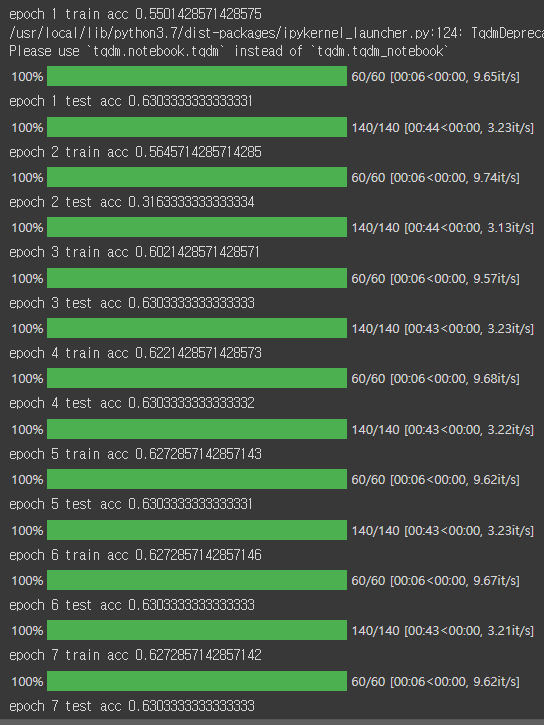

- **한계점 및 보완사항**

1. 신청절차, 성별, 자녀, 정책지원유형 등은 라벨에 중복되는 값이 없음. 그러나 그 외의 특성들은 라벨에 중복되는 값들이 있는데, 라벨값이 하나일수도, 열 개일수도 있음.
```
policy_label['신청절차'] = ['무관', '무관', '여성', '남성'...] 
policy_label['대상특성'] = ['해당사항없음', '장애인, 다문화가족', '임신부', '독거노인, 기관/시설, 장애인', '해당사항없음'...]
```

  이 부분에 대해 학습 시, loss를 데이터 갯수에 맞게 그때그때 구해주려고 해보았으나, 결국 최종적으로 test에서 n개의 아웃풋 결과를 설정해줘야함.
  ```
  out = model(token_ids, valid_length, segment_ids)
  label = label[0]
  
  if ',' in label:          
      labels = list(map(int, label.split(',')))
      loss = 0
      for i in range(len(labels)):
        label = labels[i]
        # label = tuple(label, )
        label = torch.from_numpy(np.array([np.int32(label)])).long().to(device)
        loss += loss_fn(out, label)
        loss /= len(labels)
  else:
    label = torch.from_numpy(np.array([np.int32(label)])).long().to(device)
    loss = loss_fn(out, label)
  loss.backward()
  ```

</br>

2. 학습에 사용된 라벨값은 기존에 for문, if문을 이용해서 키워드를 기준으로 태깅을 진행한 값이다.

  즉, 100%의 정확도를 가지는 라벨값이 아니라, 피처마다 최소 40% 최대 98% 사이의 정확도를 가지는 라벨값이기 때문에 애초에 높은 모델 성능을 기대하기 어려움.

---

---

<br>

<br>


# 추천 모델


## 1. 전체 데이터 이용 추천모델

주어진 전체 유저데이터셋과 정책 데이터셋을 이용해 딥러닝 모델 진행하는 방법

### 1) Wide & Deep  `=> 추후 진행할 방향`

* 선정 이유:  
  - 도메인 특성상 추천될 아이템의 조건에 유저의 조건이 부합해야 유저 경험을 강화할 수 있는데, Wide & Deep의 wide part에서 memorization을 이용해 반드시 조건을 부합하면서도 deep part의 generalization을 통해 freshness를 높이고자 선정

#### 가설)  
**Wide part에서 유저의 정보와 정책의 정보가 일치(조건에 부합)하도록 유지하면서 Deep part를 통해 조건 내 다양한 정책을 추천할 수 있을 것이다.**


* 방법:  
  a) label: 유저가 선호하는 정책의 종류(11개)가 정책데이터의 종류 특성과의 일치여부에 따라 1,0으로 부여하는 방법  
    - 유저데이터셋의 '선호정책' feature는 중복선택이 가능하므로 one-hot 인코딩을 통해 선호정책 종류를 파악   
    - 정책데이터셋의 feature에서 유저데이터셋의 '선호정책' feature의 카테고리 클래스에 부합할 수 있는 키워드를 찾아 유저데이터와 같이 one-hot 인코딩으로 표기   
    - 유저데이터 선호정책과 정책데이터의 선호정책 중 모두 1인 feature가 있는 경우 label 1을 부여, 없을 경우 0으로 처리   

  b) label: 유저와 정책 feature가 일치하는 클래스(태그)를 갖는지 여부에 따라 1,0으로 부여하는 방법
    - a)와 마찬가지로 중복 답변에 대한 처리를 위해 특정 feature의 요소를 ont-hot 인코딩 진행

    - 유저와 정책 데이터에서 매칭되는 태그(조건)의 빈도를 찾아 모든 조건과 일치하거나, N개 이상 일치할 경우 경우 label 1을 부여, 그 외는 0으로 처리

  a,b 공통)  
    - wide part(w/ cross product transformation) & deep part input 진행 및 학습  
    - 예측된 결과 리스트에서 유사도를 통한 scoring  
    - 가장 높은 점수의 정책 5개 ~10개 추천 진행 

* 이슈 및 특이사항:  
  a) a방법으로 진행하는 경우
    - 유저의 '관심정책' feature는 추천 모델의 성능 개선에 기여할 수 있는 feature이지만, 단순히 label로 사용한다는 단점.

  b) b방법으로 진행하는 경우
    - 관심정책으로 성능을 개선시킬 수  있지만, label을 생성하는데에 모든 유저와 정책의 feature를 파악하여 라벨링해야 하므로 공수가 많이 든다는 단점.

  a,b 공통) 공통적인 이슈사항
    - 궁극적으로 전체 고객 * 정책을 모두 매칭해야하므로 학습량이 너무 많아 전체 학습을 할 수 없음  
    (유저 약 20000개, 정책 약 88000개 > 유저 * 정책 = 8억8천만 샘플) 
    
    ㄴ> 이를 해결하기 위해 대표 샘플링, 클러스터링 샘플링 진행이 필요


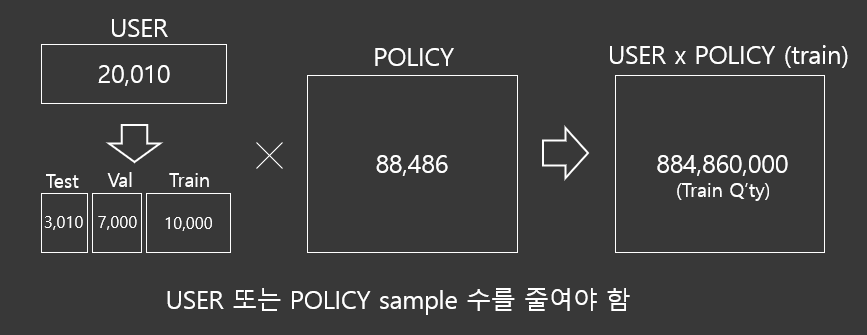

<br>


---

<br>

## 2. 데이터 선별 + 추천 진행 모델

일차적으로 유사도기반 모델로 선별하여 진행하는 모델

### (Baseline) 유사도 Matrix 모델:  
유저 데이터셋과 정책 데이터셋의 공통된 feature 요소에 대해 행렬곱을 취해 만들어진 최종 유저/정책 matrix에서 해당 유저에게 가장 높은 score를 띄는 정책을 선별하는 Baseline 모델




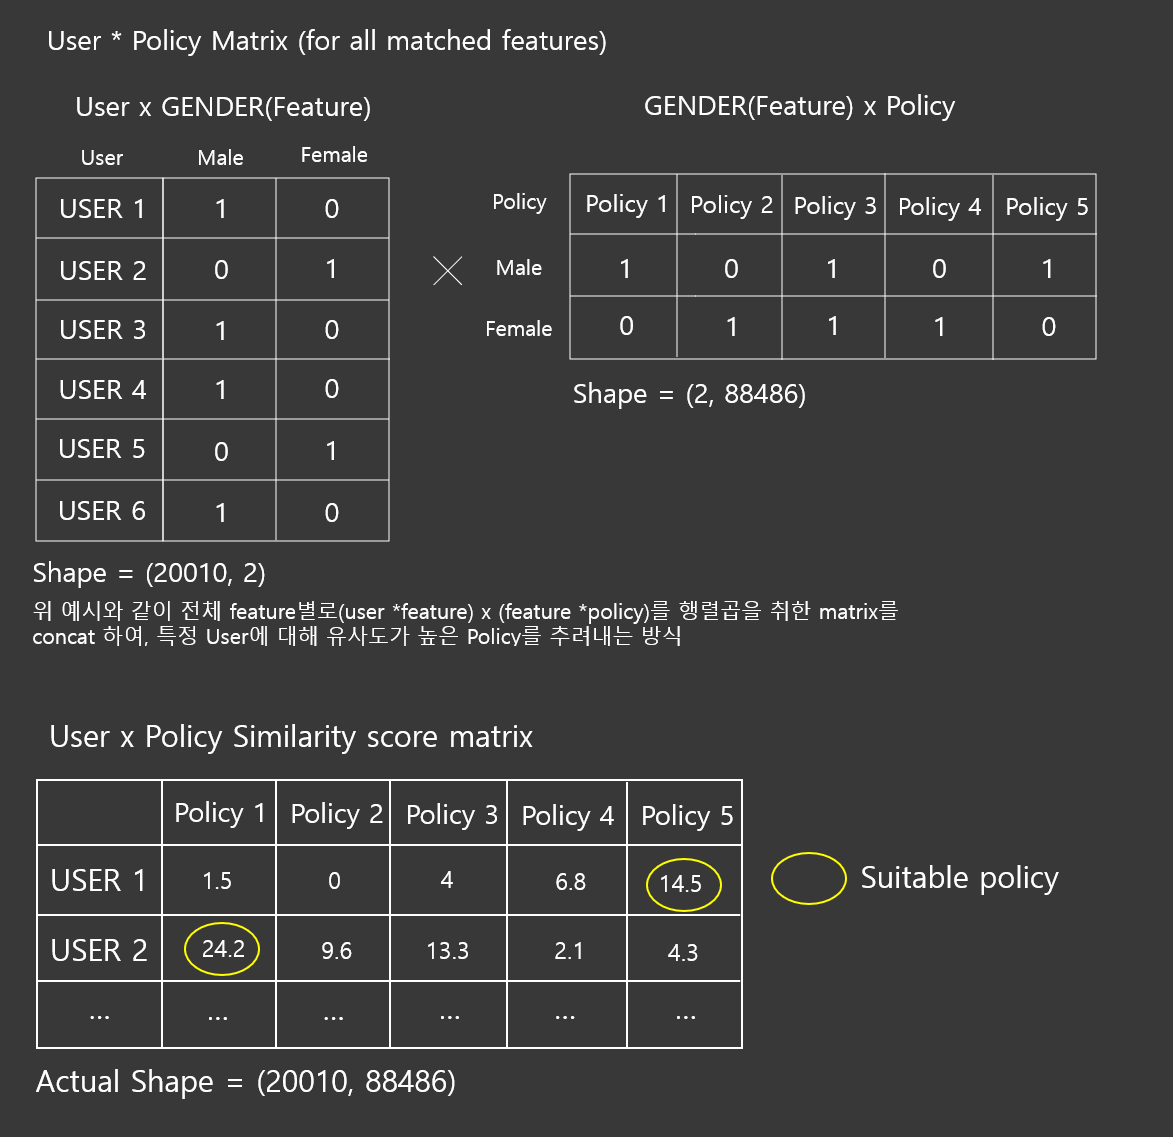

---

<br>

### 1) 유사도 모델(Baseline model) + NCF(Neural Collaborative Filtering)

* 선정 이유:  
  a) 유사도 Matrix 모델 선정:  
    - 정책 데이터가 너무 많으므로 basic한 유사도 모델을 통해 고객이 관심을 가질만한 정책을 일차적으로 선별하기 위함.  

  b) NCF 모델 선정:  
    - 일차적으로 선별된 수량에 대해 GMF part에서 유저id, 정책id의 gerenalized MF를 이용해 유저-정책 간의 연관성을 선형적(단순한 관계)으로 파악하도록 하고, MLP part에서 좀 더 복잡한 관계를 읽어내어 유저-정책 간의 고도화된 관계를 파악해 추천하는 모델을 이용하기 위함. 

#### 가설)  
**각각의 feature에 대한 특징을 담고있는 수치를 통해 Matrix를 만들고, 이를 바탕으로 NCF 모델을 학습하면, 유저-정책의 선형적, 비선형적 관계를 파악해 추천하는 모델이 될 수 있다.**

* 방법:  
  - GMF part에서 유저데이터와 정책데이터의 feature를 각각 1차원으로 압축해 matrix 상에 유저가 관심이 있는 정책일 경우 label 1을 부여, 아닐 경우 0을 부여한다.
  - MLP part에서 유저 feature와 정책 feature를 각각 임베딩 layer로 넣어 concat한 뒤 feed forward를 진행한다. 라벨은 GMF와 같은 원리로 부여해서 학습 진행
  - Metric을 hit ratio로 두어 top K를 뽑아 추천을 진행한다. 
   
* 이슈 및 특이사항:  
  - GMF 상의 Input값에 기존 NCF 논문 상에서 유저ID와 정책ID만으로 matrix를 만들어 요소 자체가 1차원으로 구성되어 있지만, 본 프로젝트의 데이터를 통해 다양한 feature를 의미가 있는 1차원 데이터로 압축하는 방법을 찾지 못함.  
  ㄴ> 기존 GMF의 Input값에 대한 이해도가 부족했던 것으로 확인. 의도대로 진행한다면 NCF와는 다른 모델이 된다.
  - 기존 NCF 모델의 GMF를 이용해 모델링을 진행할 경우, 특성이 매우 많아 MLP(DNN) part는 임베딩 레이어 자체가 아주 많아지며, 무겁고 복잡한 모델이 될 수 있음
  - 위와 같이 모델링 진행할 경우, 다양한 관계를 파악하긴 좋지만, 유저에게 조건이 부합하지 않는 정책이 추천될 수 있다.


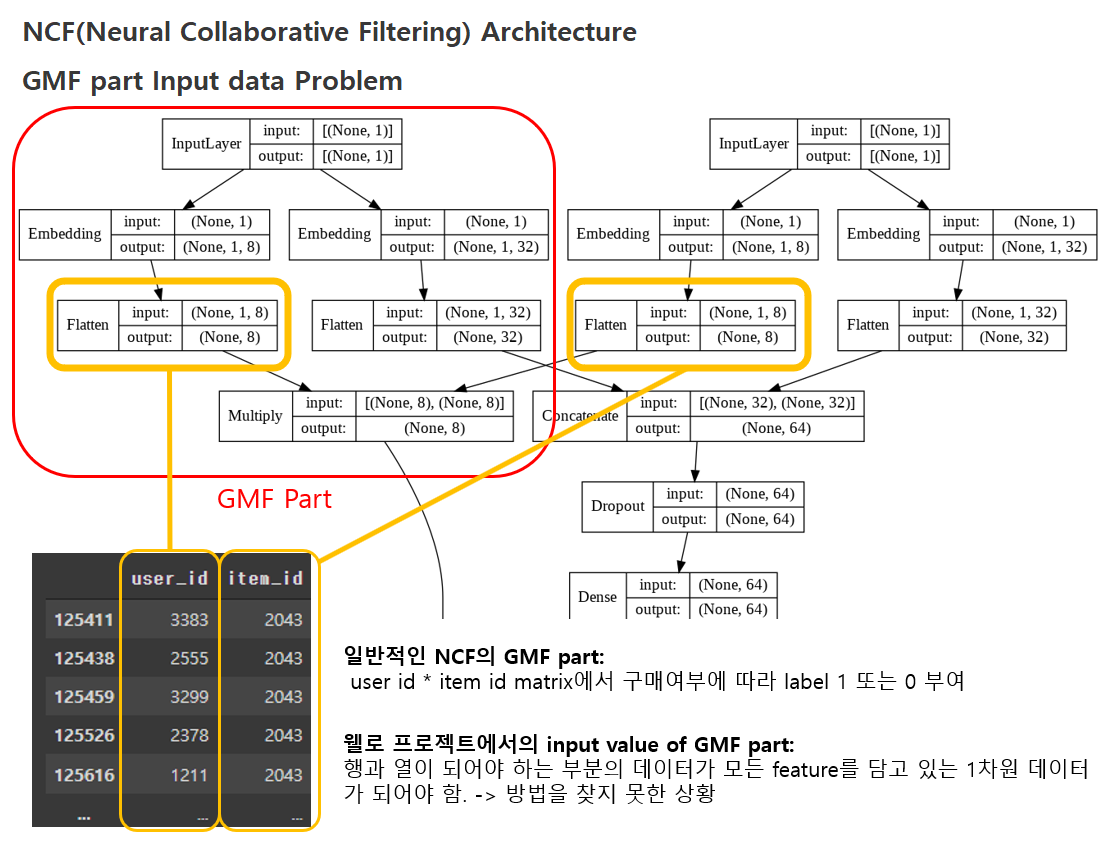



<br>

---

<br>


### 2) 유사도 모델(Baseline model) + Feature 요소 벡터화 및 요소 별 대표 샘플 추출 + 딥러닝 모델(딥러닝 진행못함)

* 선정 이유:  
  - 유사도 모델 이후에도 정책 데이터 수가 너무 많기 때문에 이차적으로 샘플 데이터를 선별하기 위해 정책의 feature 요소들을 모두 벡터화 한 뒤, 해당 벡터화 된 요소들 중 대표가 될 수있는 데이터를 뽑아 대표군들로만 모델을 학습시키기 위함

#### 가설)  
**Feature 요소를 수치화 했을 때, 대표가 될 수 있는 샘플을 선정할 수 있다.**

* 방법:  
  - 정책 데이터의 각 feature를 dense vector화를 진행
  - 수치화된 데이터를 n개의 계층으로 구분하고, n개의 계층 중 k개를 선발.
  - 해당 대표 데이터로 추천 신경망 모델 학습을 진행.

* 이슈 및 특이사항:  
  - 데이터를 수치화 했을때, 가까운 수치를 가진 유저끼리 비슷한 성향을 가진 유저라고 단정지을 수 있는 근거가 없다.

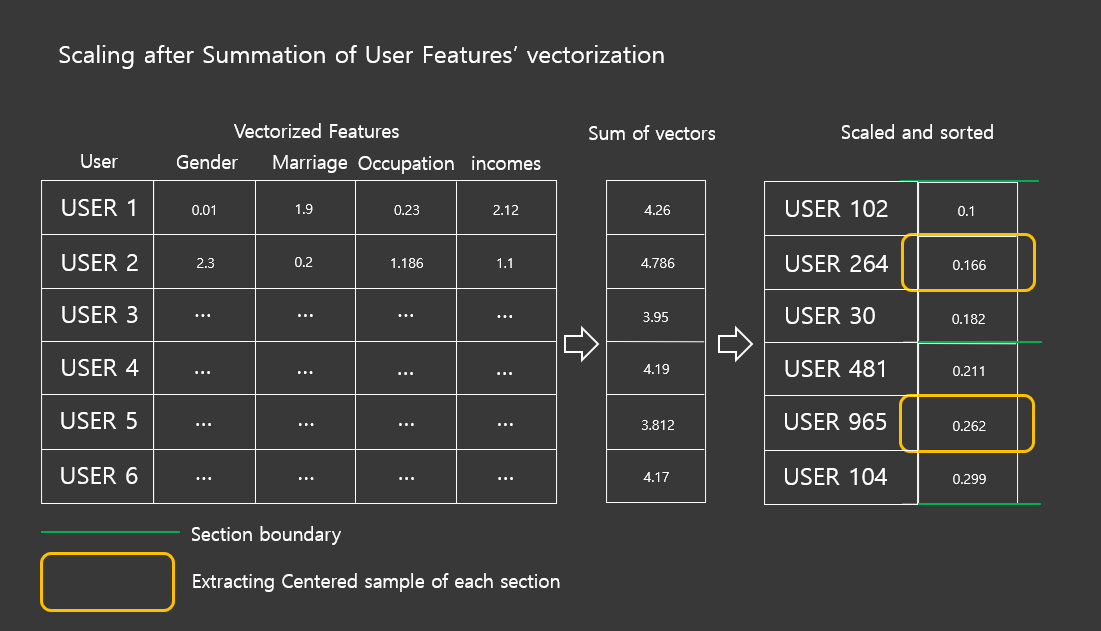


<br>

---

<br>


### 3) 유사도 모델(Baseline model) + 클러스터링을 통한 군집화 후 샘플 추출 + 딥러닝 모델(딥러닝 진행못함)

* 선정 이유:  
  - 유사도 모델 이후에도 정책 데이터 수가 너무 많기 때문에 이차적으로 샘플 데이터를 선별하기 위해 정책 데이터를 군집화 한 뒤, 해당 군집 내에서의 샘플 n개를 추출해서 학습으로 사용하여 학습 데이터 수를 줄이기 위함.

#### 가설)  
데이터의 군집화를 진행한 뒤 샘플링을 한다면, 대표 군집 내의 데이터를 일정 수량 추출해 전체 학습해야 할 정책 데이터 수를 줄일 수 있을 것이다.

* 방법:  
  - 정책 데이터의 각 numerical / categorical feature를 구분한다.
  - k-prototypes 클러스터링을 진행하여 numerical, categorical data 모두에 대한 군집화를 진행
  - 군집을 대표군으로 보고 군집별 n개씩의 샘플을 추출해 추천시스템 신경망 모델의 인풋으로 이용한다.
  -(optional) Umap 모듈 임베딩을 이용해 2차원 시각화 진행 군집 확인

* 이슈 및 특이사항:  
  - numerical & categorical 특성이 모두 존재해 k-prototypes로 군집화를 진행
  - 적은 feature로 군집화 진행시, 시각화에서도 직관적으로 납득되는 군집을 형성
  -  feature 수가 많아질 경우, 직관적 납득이 어려움  
  ㄴ> 예상 원인: 
  특성의 차원이 너무 높기 때문에 이를 2차원으로 축소했을 때의 군집화는 실제 보이는 샘플의 위치와 다를 수 있다. (umap시각화의 한계)

#### 적은 수의 Feature Clustering 시각화
Features : '대상연령시작','대상연령끝','성별','신청절차'

2차원 시각화 시, 군집 별로 다른 class가 섞이지 않고 잘 나뉜것을 확인할 수 있음


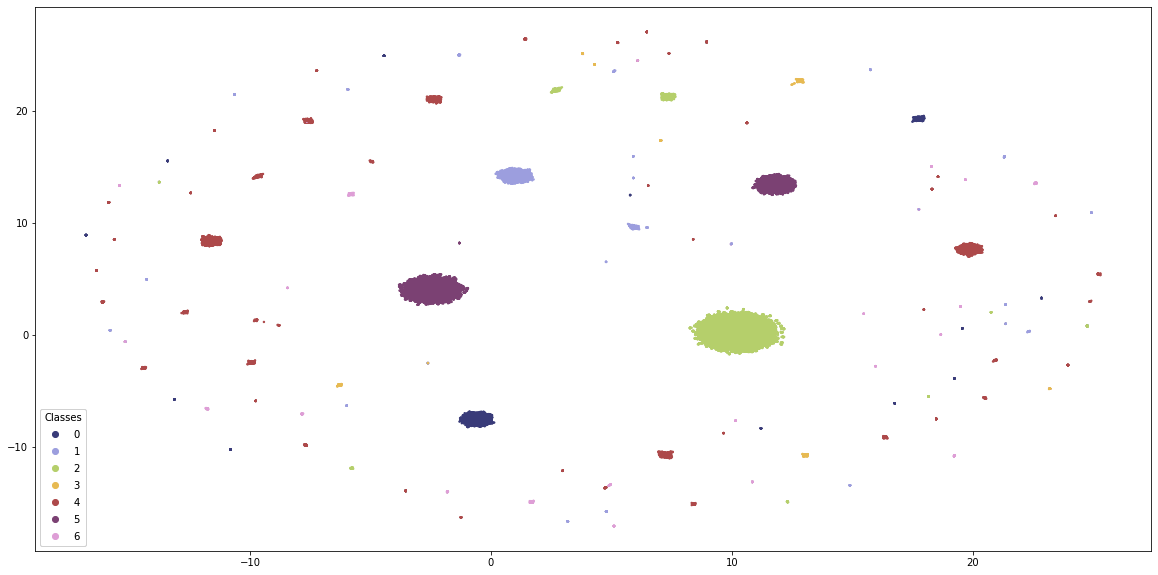

#### 많은 수의 Feature Clustering

Features: 전체 features

feature가 많아지면서 각 feature들 간의 복잡한 관계가 생겨서인지, 시각적으로 모여있는 샘플들 안에 서로다른 class가 섞여있는 것을 볼 수 있음.

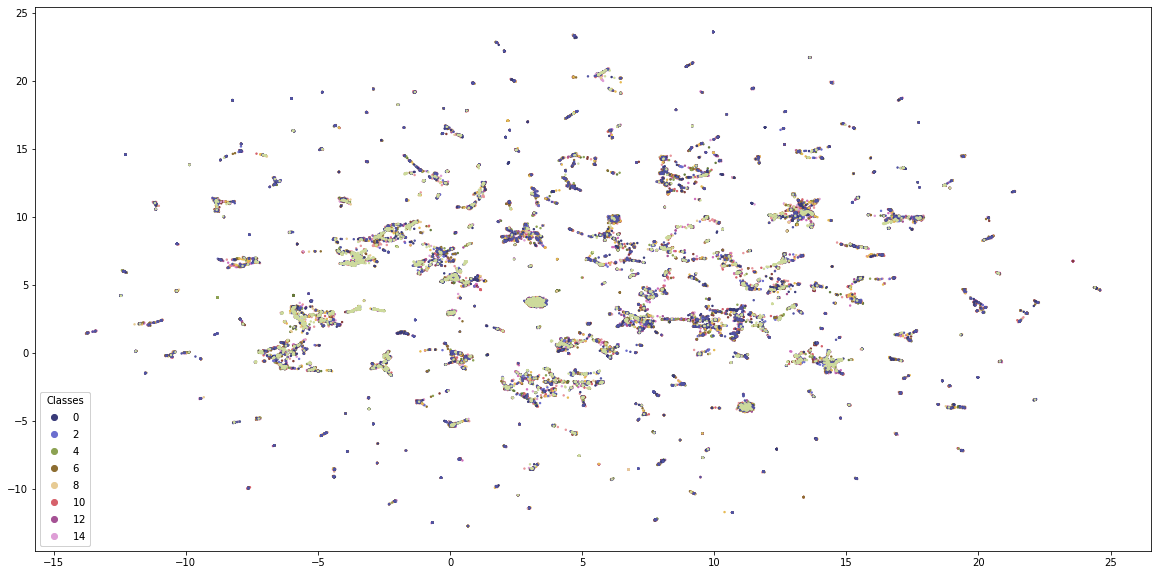